In [1]:
# /root/autodl-pub/ImageNet
import torchattacks
import torch
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAMpp, GradCAM
import torchvision.models as models
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import os
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
from torchvision import models
import torch
 
#dir(models)

In [3]:
# net = models.resnet18(pretrained = True)
net = models.mobilenet_v2(pretrained = False)
net_dir = 'models/mobilenet_v2-b0353104.pth'
net.load_state_dict(torch.load(net_dir))
net.eval()

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [4]:
from torchvision import transforms
transform = transforms.Compose([            #[1]
 transforms.Resize(256),                    #[2]
 transforms.CenterCrop(224),                #[3]
 transforms.ToTensor(),                     #[4]
 transforms.Normalize(                      #[5]
 mean=[0.485, 0.456, 0.406],                #[6]
 std=[0.229, 0.224, 0.225]                  #[7]
 )])

In [5]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "autodl-tmp/imagenet100/n02086910/n02086910_1314.JPEG"
img = Image.open(image_path).convert('RGB')

In [6]:
input_image = transform(img)
input_image = input_image.unsqueeze(0)  # 添加批次维度

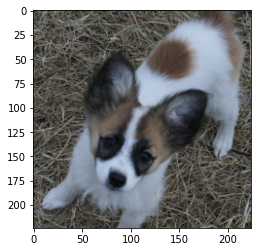

In [8]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
orig_image = input_image[0].numpy().transpose(1, 2, 0) 
orig_image = orig_image * std + mean
plt.imshow(orig_image)
plt.show()

In [9]:
net.eval()
out = net(input_image)
print(out.shape)

torch.Size([1, 1000])


In [10]:
with open('imagenet_classes.txt') as f:
    classes = [line.strip() for line in f.readlines()]

In [11]:
_, index = torch.max(out, 1)
 
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
label_idx = int(index[0])
print(classes[label_idx], percentage[index[0]].item())

papillon 88.92154693603516


In [12]:
# PGD
y_true = label_idx   #change this if you change input image
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)

tensor([157])


In [13]:
# 将图像tensor归一化到0-1中
min_val = torch.min(input_image)
max_val = torch.max(input_image)
input_image_normalized = (input_image - min_val) / (max_val - min_val)

In [14]:
eps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
attack = torchattacks.PGD(net, eps=eps[3])
# perturbed_data = (torchattacks.BIM(model, epsilon, 0.2, steps=4))
perturbed_data = attack(input_image_normalized, target)

In [15]:
noise = perturbed_data - input_image_normalized

In [16]:
# 去标准化
perturbed_data = perturbed_data * (max_val - min_val) + min_val

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


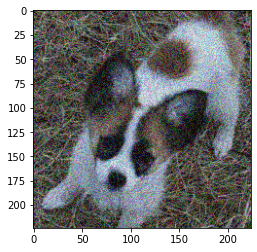

In [17]:
adv_image = perturbed_data[0].numpy().transpose(1, 2, 0)  # 交换通道
adv_image = adv_image * std + mean
plt.imshow(adv_image)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


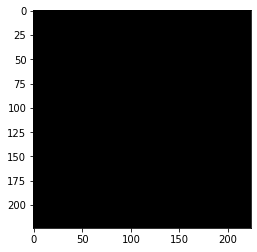

In [18]:
noise = noise * (max_val - min_val) + min_val
noise_map = noise[0].cpu().numpy().transpose(1, 2, 0)  # 交换通道
adv_image = adv_image * std + mean
plt.imshow(noise_map)
plt.show()

In [19]:
# 计算图像质量指标
import pytorch_ssim

def psnr(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    mse = F.mse_loss(img1.float(), img2.float())
    psnr = 10 * torch.log10(1/mse)
    return psnr

def mse(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    mse = F.mse_loss(img1.float(), img2.float())
    return mse

def ssim(img1, img2):
    img1 = img1.cpu()
    img2 = img2.cpu()
    ssim = pytorch_ssim.ssim(img1.float(), img2.float())
    return ssim

In [20]:
mse(perturbed_data, input_image).item()

0.2345266342163086

In [21]:
ssim(input_image, perturbed_data).item()

0.3577665090560913

In [22]:
psnr(perturbed_data, input_image).item()

6.298078536987305